# Power and false positives

Peter Ralph

https://uodsci.github.io/dsci345

In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15, 8)
import numpy as np
import pandas as pd

rng = np.random.default_rng()

$$\renewcommand{\P}{\mathbb{P}} \newcommand{\E}{\mathbb{E}} \newcommand{\var}{\text{var}} \newcommand{\sd}{\text{sd}}$$
This is here so we can use `\P` and `\E` and `\var` and `\sd` in LaTeX below.

# Power analysis

Suppose we're measuring expression
of many ($\sim$ 1,000) genes
in a bunch of organisms at night and during the day.
We'd like to know which genes are expressed 
at different levels in night and day, and by how much.

However, gene expression is highly variable: some genes
differ much more between individuals than others.
Here's a model for $X$, the difference in log gene expression
of a random gene in a random individual:
$$ \begin{aligned}
    \text{mean difference:} \qquad M &\sim \begin{cases} 3 \qquad &\text{with probability}\; 1/2 \\ 0 \qquad &\text{with probability}\; 1/2 \end{cases} \\
    \text{SD difference:} \qquad D &\sim \text{Exponential}(\text{mean}=2) \\
    \text{measured difference:} \qquad X &\sim \text{Normal}(\text{mean}=M, \text{sd}=D) .
\end{aligned}$$

*Goals:* We will want to, in the real data,

- Identify genes that we're sure are differentially expressed.
- Estimate how different their expression levels are.

So, let's simulate from this and test out our methods.

## Simulate

In [2]:
n = 1000  # number of genes
num_samples = 20
M = rng.choice([0, 3], size=n)
D = rng.exponential(scale=2, size=n)
X = np.array([rng.normal(loc=M, scale=D, size=n) for _ in range(num_samples)])
mean_X = np.mean(X, axis=0)  # mean per gene
sd_X = np.std(X, axis=0)  # sd per gene

In [3]:
X.shape, mean_X.shape

((20, 1000), (1000,))

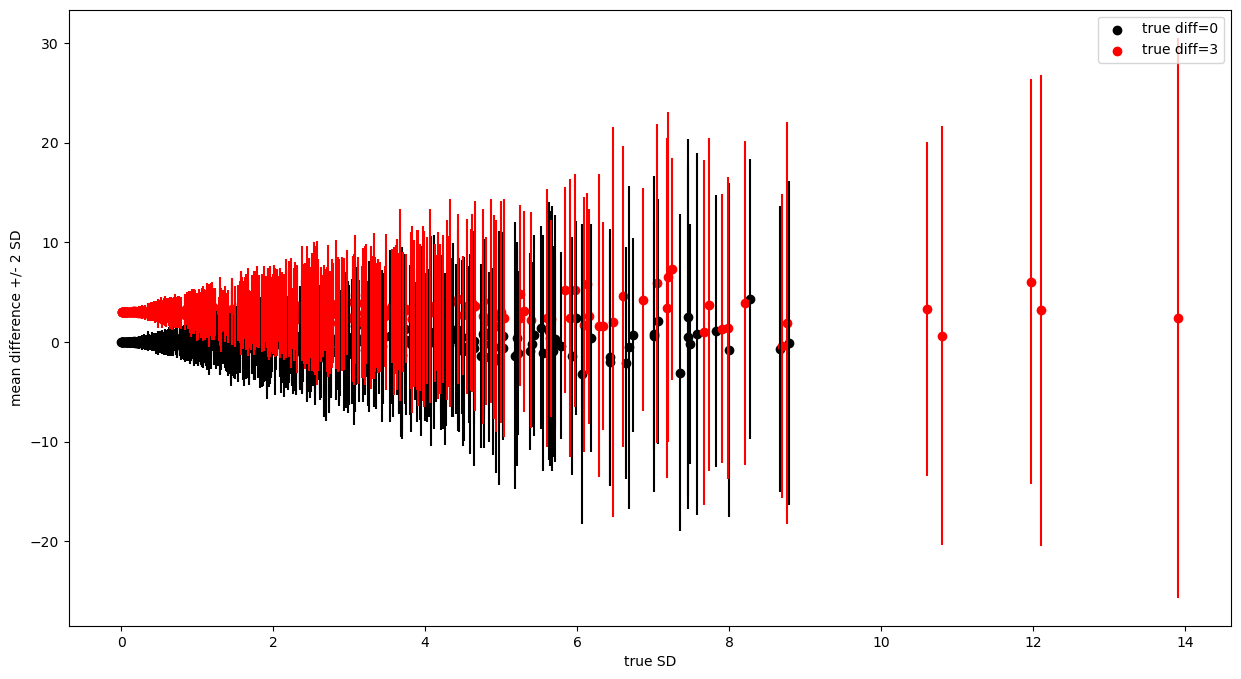

In [4]:
from matplotlib.collections import LineCollection
fig, ax = plt.subplots()

for Mval, col in [(0, 'black'), (3, 'red')]:
    ut = (M == Mval)
    segs = [[(d, m - 2 * s), (d, m + 2 * s)] for d, m, s in zip(D[ut], mean_X[ut], sd_X[ut])]
    ax.add_collection(LineCollection(segs, colors=col))
    ax.scatter(D[ut], mean_X[ut], c=col, label=f'true diff={Mval}')

ax.set_xlabel("true SD"); ax.set_ylabel("mean difference +/- 2 SD")
ax.legend();

## Methods

How will we identify differentially expressed genes?
For each gene, let's (a) do a $t$-test, and (b) find a 95% confidence interval.
Then, we'll take the genes with $p$-value below $\alpha$ as candidate differentially expressed genes,
and use the confidence intervals to estimate (a range on) how differently they are expressed.

First, the $t$-tests, with `scipy.stats.ttest_1samp()`:

In [ ]:
import scipy.stats

tt = scipy.stats.ttest_1samp(X, axis=0, popmean=0)

fig, ax = plt.subplots()
for Mval, col in [(0, 'black'), (3, 'red')]:
    ut = (M == Mval)
    ax.scatter(mean_X[ut], tt.pvalue[ut], color=col, label=f'true diff={Mval}')
    
ax.set_xlabel("mean difference")
ax.set_ylabel("p-value")
ax.legend();

Next, the confidence intervals:

In [ ]:
from scipy.stats import t
t_star = t.ppf(.975, df=num_samples - 2)

lower_ci = mean_X - t_star * sd_X / np.sqrt(num_samples)
upper_ci = mean_X + t_star * sd_X / np.sqrt(num_samples)
# put plot in order by observed mean diff
m_ord = np.argsort(np.argsort(mean_X))

fig, ax = plt.subplots()
ax.set_xlabel("dataset (ordered by observed difference)")
ax.set_ylabel("observed mean difference")
for Mval, col in [(0, 'black'), (3, 'red')]:
    ut = (M == Mval)
    lc = LineCollection([[(m, li), (m, ui)] for m, li, ui in zip(m_ord[ut], lower_ci[ut], upper_ci[ut])], color=col)
    ax.add_collection(lc)
    ax.scatter(m_ord[ut], mean_X[ut], c=col, label=f'true diff={Mval}')
    
ax.legend();

## The power analysis

Okay, that shows us visually that things are working as we expect.
Now:

1. What proportion of truly differentially expressed genes do we "detect" (i.e., have $p < 0.05$)?
2. Are the confidence intervals well calibrated (i.e., contain the true mean 95% of the time)?

In [ ]:
candidates = np.where(tt.pvalue < 0.05)[0]
true_pos = np.sum(M[candidates] > 0) / np.sum(M > 0)
false_pos = np.sum(M[candidates] == 0) / len(candidates)
print(f"Proportion of differentially expressed genes detected (power): {true_pos:.2f}")
print(f"Proportion of canddiate genes that are not differentially expressed (false positive rate): {false_pos:.2f}")

**Exercise:** How to check calibration of the confidence intervals?